In [1]:
using LowRankModels, Plots, Random
pyplot()

Plots.PyPlotBackend()

LowRankModels.jl is a julia package for modeling and fitting generalized low rank models (GLRMs). GLRMs model a data array by a low rank matrix, and include many well known models in data analysis, such as principal components analysis (PCA), matrix completion, robust PCA, nonnegative matrix factorization, k-means, and many more.

LowRankModels.jl makes it easy to mix and match loss functions and regularizers to construct a model suitable for a particular data set. In particular, it supports

   * using different loss functions for different columns of the data array, which is useful when data types are heterogeneous (eg, real, boolean, and ordinal columns);
   * fitting the model to only some of the entries in the table, which is useful for data tables with many missing (unobserved) entries; and
   * adding offsets and scalings to the model without destroying sparsity, which is useful when the data is poorly scaled.


# Losses

You've already seen most of the loss functions available in LowRankModels.

For real valued $y$, try:
   * quadratic loss - `QuadLoss()`
   * $\ell_1$ loss - `L1Loss()`
   * quantile loss (for $\alpha$ quantile) - `QuantileLoss(α)`
 
For Boolean $y$, try
   * hinge loss - `HingeLoss()`
   * logistic loss - `LogisticLoss()`
   * weighted hinge loss - `WeightedHingeLoss()`

For nominal $y$, try
   * multinomial loss - `MultinomialLoss()`
   * one vs all loss - `OvALoss()`
       * (by default, it uses the logistic loss for the underlying binary classifier)

For ordinal $y$, try
   * ordinal hinge loss - `OrdinalHingeLoss()`
   * bigger vs smaller loss - `BvSLoss()`
       * (by default, it uses the logistic loss for the underlying binary classifier)

In [2]:
# example loss function
loss = QuadLoss()

QuadLoss(1.0, RealDomain())

In [3]:
loss = HingeLoss()

# evaluate method: 
#   first argument is prediction w^T x
#   first argument is desired output y (must be of correct type)
evaluate(loss, 1., 1)

0.0

In [4]:
# for ordinal and categorical losses, don't forget to specify number of levels
loss = BvSLoss(4) # ordinal loss on 4 levels 

BvSLoss(4, LogisticLoss(1.0, BoolDomain()), 1.0, OrdinalDomain(1, 4))

# Regularizer

We've also seen many of the regularizers available:

   * no regularization - `ZeroReg()`
   * quadratic regularization - `QuadReg()`
   * $\ell_1$ regularization - `OneReg()`
   * nonnegative constraint - `NonNegConstraint()`
   * constrained squared euclidean norm - `QuadConstraint()`
   * nonnegative constraint - `NonNegConstraint()` (eg, for nonnegative matrix factorization)
   * 1-sparse constraint - `OneSparseConstraint()` (eg, for orthogonal NNMF)
   * unit 1-sparse constraint - `UnitOneSparseConstraint()` (eg, for k-means)
   * simplex constraint - `SimplexConstraint()`
   * l1 regularization, combined with nonnegative constraint - `NonNegOneReg()`
   * fix features at values y0 - `FixedLatentFeaturesConstraint(y0)`

In [5]:
# regularizers
lambda = 1

nonneg = NonNegConstraint()
l1 = OneReg(lambda)
l2 = QuadReg(lambda)

QuadReg(1.0)

# Generalized Low Rank Models

GLRMs form a low rank model for tabular data A with m rows and n columns, which can be input as an array or any array-like object (for example, a data frame). It is fine if only some of the entries have been observed (i.e., the others are missing or NA); the GLRM will only be fit on the observed entries $\Omega$.

The desired model is specified by choosing a rank k for the model, an array of loss functions losses, and two regularizers, $r_x$ and $r_w$. The data is modeled as $X^TW$, where $X$ is a $k\times m$ matrix and $W$ is a $k\times n$ matrix. $X$ and $W$ are found by solving the optimization problem

$$\min \sum_{(i,j) \in \Omega} \ell_j\bigg((X^TW)[i,j], Y[i,j]\bigg) + \sum_i r_x(X[:,i]) + \sum_j r_y(W[:,j])$$

To form a GLRM, the user specifies

   * the data $Y$ (any AbstractArray, such as an array, a sparse matrix, or a data frame)
   * the array of loss functions $\ell$
   * the regularizers $r_x$ and $r_w$
   * the rank $k$
   * the observations $\Omega$


In [6]:
# example: nonnegative matrix factorization
Random.seed!(0)
Y = randn(10, 10)
Y = randn(10,3) * randn(3,10)
loss = QuadLoss()
nonneg = NonNegConstraint()
k = 5
Ω = [(rand(1:10), rand(1:10)) for iobs in 1:50] # observe 50 random entries, with replacement
glrm = GLRM(Y, loss, nonneg, nonneg, k, obs=Ω);

In [7]:
# example: matrix completion
Random.seed!(0)
Y = randn(10, 10)
Y = randn(10,3) * randn(3,10)
loss = QuadLoss()
reg = QuadReg(.01)
k = 5
Ω = [(rand(1:10), rand(1:10)) for iobs in 1:50] # observe 50 random entries, with replacement
glrm = GLRM(Y, loss, reg, reg, k, obs=Ω);

In [8]:
# To fit the model, call
X,W,ch = fit!(glrm);

Fitting GLRM
Iteration 10: objective value = 0.5072112529479731
Iteration 20: objective value = 0.4034448232453027


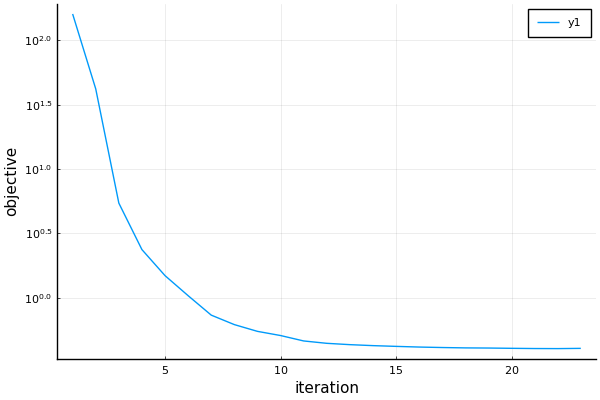

In [9]:
# did it converge? 
plot(ch.objective[2:end])
xlabel!("iteration")
ylabel!("objective")
yaxis!(:log)

This runs an alternating directions proximal gradient method on glrm to find the $X$ and $W$ minimizing the objective function.

In [10]:
X

5×10 Array{Float64,2}:
 -0.422993   0.537001  -0.14254    …   0.33599   -1.21547    1.82189
  0.28939   -0.143836  -0.428139      -2.06635   -0.050295  -0.988493
 -0.483446   0.165126   0.0177681      0.341715  -0.782417   1.05648
  0.536504   0.718997   3.44137        0.745075   0.42256    0.306294
  0.222678  -0.984578   2.1589        -2.04808    0.94132    1.0437

In [11]:
W

5×10 Array{Float64,2}:
  0.436782  -0.636849    0.264405  …   0.28723    -2.02259    -0.432754
 -0.353875  -0.104756    1.04007      -0.580977   -0.865213   -0.48482
 -1.47991   -0.847183    0.40167      -0.821694    0.0748491   0.00909274
  0.50097    0.63491     0.109833      0.961063   -0.597003   -1.49089
 -1.19372   -0.0387582  -0.62859       0.0137478   0.332749    0.0762983

To allow further convergence, try running for more iterations. 
You can just call fit!(glrm) again, or increase the number of iterations.

In [12]:
fit!(glrm)

Fitting GLRM
Iteration 10: objective value = 0.3954898824323545


([-0.4030223706897124 0.49407507233115583 … -1.219142449592204 1.82212314257801; 0.3433151711722622 -0.04417723951314076 … -0.030045429502211257 -1.0267330385487543; … ; 0.48845512237765715 0.695560045555311 … 0.40298044707346553 0.28067712287401153; 0.18914742324022163 -0.885184999541803 … 0.898739017519355 1.0012426425142709], [0.38920333290036147 -0.6626169803748427 … -1.9912901344427008 -0.38215882691279107; -0.3583083624705301 -0.10362757069028869 … -0.7974590635989376 -0.4646467579220208; … ; 0.48178217178057187 0.6103148503701175 … -0.592301480812159 -1.5015059127613541; -1.2058846976593152 -0.0003386878740977817 … 0.35252383892795536 0.11035934576759086], ConvergenceHistory("ProxGradGLRM", [0.9695801422434679, 0.4006938877106781, 0.39892701398883645, 0.3976932567991586, 0.39742602488908135, 0.39778907693672183, 0.3974663867919105, 0.39701018863239634, 0.39733563963392804, 0.39760462581787037, 0.3954898824323545, 0.3946991922399685, 0.39327089163393475, 0.392746007269617, 0.3920

## Impute missing values

In [13]:
# predicted values for all entries
impute(glrm)

10×10 Array{Number,2}:
  0.378116    0.904787   -0.000227892  …   0.618643   0.290859    -0.712295
  1.29706    -0.0788419   0.791745         0.770491  -1.66529     -1.31314
 -0.793931    2.19608    -1.25741          3.45891   -0.632055    -4.57071
  4.25604     2.45115    -0.129716         2.16835    0.868303    -0.25577
  0.171468    0.0250508   0.422249         0.562584  -1.35326     -1.29725
 -0.0131672   0.526358    0.0942851    …  -1.00181    2.21502      1.47537
 -1.0319      0.149035   -0.260814        -0.425777   2.83878      0.123599
  3.18883     0.185706   -0.47076          1.94501    0.00889723  -0.377534
 -0.276901    1.67734    -1.09317          0.730898   2.50452     -0.0165131
 -1.51349    -1.80562    -0.698543         0.216109  -2.58727     -0.543634

In [14]:
# predicted values for missing entries; observed values for observed entries 
impute_missing(glrm)

10×10 Array{Number,2}:
  0.378116    0.904787   -0.000227892  …   0.61373    0.290859  -0.712295
  1.29706    -0.0788419   0.791745         0.76337   -1.66529   -1.31561
 -0.783816    2.19608    -1.25741          3.45891   -0.632055  -4.57071
  4.25604     2.45115    -0.129716         2.16489    0.868303  -0.25577
  0.167164    0.0250508   0.430701         0.562584  -1.35326   -1.31139
 -0.0131672   0.535275    0.0919553    …  -1.0238     2.21502    1.47676
 -1.0319      0.149035   -0.268356        -0.419438   2.84577    0.125825
  3.19479     0.185706   -0.47076          1.94501    0.015885  -0.377534
 -0.276901    1.68469    -1.09317          0.723536   2.50967   -0.0175466
 -1.51285    -1.80901    -0.698543         0.216109  -2.58703   -0.543634

# Initialization

You'll also often improve convergence, or even converge to a better solution, with good initialization:

Fitting GLRM
Iteration 10: objective value = 3.3088414816755822
Iteration 20: objective value = 1.6874888891858972
Iteration 30: objective value = 1.5900191600399955
Iteration 40: objective value = 1.5312421374086584
Iteration 50: objective value = 1.4757169513573956
Iteration 60: objective value = 1.4288124932948265
Iteration 70: objective value = 1.382750197797223
Iteration 80: objective value = 1.3367054383984835
Iteration 90: objective value = 1.2975118848680802
Iteration 100: objective value = 1.2562925019496296


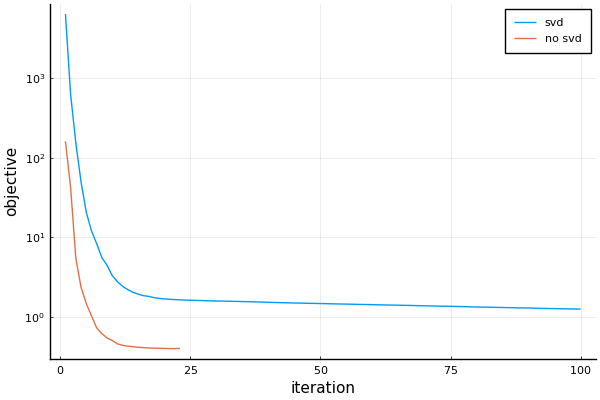

In [15]:
init_svd!(glrm)
X,W,ch_svd = fit!(glrm)
plot(ch_svd.objective[2:end], label="svd")
plot!(ch.objective[2:end], label="no svd")
xlabel!("iteration")
ylabel!("objective")
yaxis!(:log)

# Treating different columns differently
The losses argument can also be an array of loss functions, with one for each column (in order). For example, for a data set with 4 columns, you could use:

In [16]:
losses = Loss[QuadLoss(), LogisticLoss(), HingeLoss(), BvSLoss(4)]

4-element Array{Loss,1}:
 QuadLoss(1.0, RealDomain())
 LogisticLoss(1.0, BoolDomain())
 WeightedHingeLoss(1.0, BoolDomain(), 1.0)
 BvSLoss(4, LogisticLoss(1.0, BoolDomain()), 1.0, OrdinalDomain(1, 4))

Similiarly, the $r_w$ argument can be an array of regularizers, with one for each column (in order). For example, for a data set with 3 columns, you could use:

In [17]:
rw = Regularizer[QuadReg(1), QuadReg(10), OneReg()]

3-element Array{Regularizer,1}:
 QuadReg(1.0)
 QuadReg(10.0)
 OneReg(1.0)

# Example: PCA

In [18]:
# minimize ||Y - XW||^2
function fit_pca(m,n,k)
	# matrix to encode
	Y = randn(m,k)*randn(k,n)
	loss = QuadLoss()
	r = ZeroReg()
	glrm = GLRM(Y,loss,r,r,k)
	X,W,ch = fit!(glrm)
	println("Convergence history:",ch.objective)
	return Y,X,W,ch
end

fit_pca (generic function with 1 method)